## Латыпов Ильяс Дамирович (DS-22)
## Домашнее задание №4.

В данном задании вам нужно будет провести анализ данных проведенного A/B-теста.

Данные будут предоставлены в формате csv. Они будут содержать также часть пред экспериментального этапа.

Описание эксперимента:

    Есть мобильное приложение. В этом приложении у пользователей есть возможность покупать игровые предметы за реальные деньги. Чтобы стимулировать пользователей их покупать, приложение периодически предлагает пользователям товары - появляется окошко с рекомендацией купить товар. Отдел машинного обучения предложил улучшение для текущего алгоритма выбора рекомендации. Для проверки улучшений алгоритма был проведен A/B тест. Лог его проведения предоставлен в прикрепленном файле. 

Метрика:

    Cредний доход от пользователя за 1 неделю после первого показа ему рекомендации на 10% (после начала A/B теста время первого показа ищется снова)

Важная информация:
    
    • Эксперимент начинается 2023-05-01. Данные есть до 2023-06-01 (но можно завершить раньше, если это позволит оценка длительности)
    • Вам сказали, что его длительность должна составить 1 месяц.
    • Все покупки, которые вызваны не влиянием рекомендаций, в этом логе не учитываются

Описание данных:

    id_product -  идентификатор продукта, который был рекомендован
    is_pay - купил ли пользователь товар
    sum_payment - размер платежа (0, если не купил)
    city - город, в котором находится пользователь
    id_user - пользователь
    timestamp - timestamp события
    date - дата события

Задачи, которые необходимо решить:

1.	Оценить длительность теста на момент его начала. Сравнить с предложенной. Для оценки необходимо использовать данные с пред экспериментального периода. Посмотреть, есть ли выбросы в данных.
2.	Построить методику расчета целевой метрики. Рассчитать целевую метрику на день окончания теста (рассчитанной в п1) для группы A и B, рассчитать эффект, p_value. Посмотреть, есть ли выбросы в данных.
3.	Рассчитать метрики из п2 по дням и построить их графики.
4.	Принять решение о результате теста - обосновать.

Дополнительно:

    При подсчете метрик обработать выбросы в данных - описать почему их можно удалить из теста, если они удаляются. Пожалуйста, не заглядывайте в будущее по данным, если рассчитанная длительность меньше предоставленных данных.
    Данные: ссылка, читать стоит с pd.read_csv("ab_made_4.gzip", compression='gzip')

In [1]:
import numpy as np
import scipy.stats as sps
import pandas as pd
from datetime import datetime, timedelta

import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Загрузка данных

In [2]:
data = pd.read_csv("ab_made_4.gzip", compression='gzip', parse_dates=['date'], dayfirst=True)
data['date'] = data['date'].apply(datetime.date)
data['date_offer'] = data['timestamp'].apply(datetime.utcfromtimestamp).apply(datetime.date)
data["group"] = data["group"].fillna("prepare")

data["id_user"] = data["id_user"].apply(lambda x: x[5:])
data["id_user"] = data["id_user"].astype(int)

data.sample(10)

,timestamp,id_user,sum_payment,group,city,id_product,is_pay,date,date_offer
22708,1682835140,7363,0,prepare,Рязань,4.0,0,2023-04-30,2023-04-30
32841,1684445064,9626,22,A,Рязань,3.0,1,2023-05-19,2023-05-18
12276,1682363566,2903,0,prepare,Санкт-Петербург,3.0,0,2023-04-24,2023-04-24
21669,1682774174,6081,0,prepare,Рязань,14.0,0,2023-04-29,2023-04-29
32618,1684462955,874,0,A,Рязань,21.0,0,2023-05-19,2023-05-19
20954,1682801303,7796,0,prepare,Москва,16.0,0,2023-04-29,2023-04-29
15895,1682576155,287,0,prepare,Рязань,5.0,0,2023-04-27,2023-04-27
19951,1682762152,4740,0,prepare,Санкт-Петербург,13.0,0,2023-04-29,2023-04-29
5999,1681799526,2547,0,prepare,Москва,14.0,0,2023-04-18,2023-04-18
26214,1683389184,1805,25,B,Ярославь,12.0,1,2023-05-06,2023-05-06


## EDA

In [3]:
# hist plot fuction
def plot_hist(datas, labels, colors, col_names, col_number=2, 
                         figsize_=(18, 8), bins_=30, log_y=False, log_x=None):
    row_numder = -(-len(col_names)//col_number)
    fig, axes_ = plt.subplots(row_numder, col_number, figsize=figsize_)
    
    if (row_numder == 1) or (col_number == 1):
        for counter_ in range(len(col_names)):
            bins_tr = bins_
            if log_x is not None:
                if log_x[counter_]:
                    axes_[counter_].set_xscale("log")
                    values_ = datas[0][col_names[counter_]].to_numpy()
                    bins_tr = np.exp(np.linspace(np.log(min(values_)), np.log(max(values_)), num=bins_+1))
            
            hist, bins_tr, _ = axes_[counter_].hist(datas[0][col_names[counter_]], rwidth=0.95, alpha=0.55, 
                                                 label=labels[0], color=colors[0], bins=bins_tr, log=log_y)
            for data_idx in range(1, len(datas)):
                axes_[counter_].hist(datas[data_idx][col_names[counter_]], rwidth=0.95, alpha=0.55, 
                                     label=labels[data_idx], color=colors[data_idx], bins=bins_tr, log=log_y)


            axes_[counter_].set_title(col_names[counter_])
            axes_[counter_].legend(loc=1)
    else:
        for counter_ in range(len(col_names)):
            pic_row_ = counter_//col_number
            pic_col_ = counter_ % col_number
            bins_tr = bins_
            if log_x is not None:
                if log_x[counter_]:
                    axes_[pic_row_, pic_col_].set_xscale("log")
                    values_ = datas[0][col_names[counter_]].to_numpy()
                    bins_tr = np.exp(np.linspace(np.log(min(values_)), np.log(max(values_)), num=bins_+1))
                 
            hist, bins_tr, _ = axes_[pic_row_, pic_col_].hist(datas[0][col_names[counter_]], rwidth=0.95, alpha=0.55, 
                                                              label=labels[0], color=colors[0], bins=bins_, log=log_y)
            for data_idx in range(1, len(datas)):
                axes_[pic_row_, pic_col_].hist(datas[col_names[counter_]], rwidth=0.95, alpha=0.55, 
                                               label=labels[data_idx], color=colors[data_idx], bins=bins_tr, log=log_y)
            if log_x is not None:
                if log_x[counter_]:
                    axes_[pic_row_, pic_col_].set_xscale("log")

            axes_[pic_row_, pic_col_].set_title(col_names[counter_])
            axes_[pic_row_, pic_col_].legend(loc=1)

In [4]:
data.groupby("group")[["date", "date_offer"]].agg(["min", "max"])

date              date_offer            
                min         max         min         max
group                                                  
A        2023-05-01  2023-05-31  2023-05-01  2023-05-31
B        2023-05-01  2023-05-31  2023-04-30  2023-05-31
prepare  2023-04-01  2023-04-30  2023-04-01  2023-04-30

#### Данные в датасете по времени соотвествуют условиям задачи 

In [5]:
data.groupby("id_user")["group"].agg(lambda x: "_".join(set(x))).value_counts()

B_prepare    5000
A_prepare    5000
A            1000
B            1000
Name: group, dtype: int64

#### Группы A и B не пересекаются по id_user

In [6]:
(data[data["is_pay"]==1]['date'] - data[data["is_pay"]==1]['date_offer']).value_counts()

0 days    13983
1 days     1801
dtype: int64

#### В основном покупки совершались в день предложения 

In [7]:
data[data["sum_payment"] >=50]["sum_payment"].value_counts()

53      142
1000      3
Name: sum_payment, dtype: int64

#### Есть выбросы по сумме покупок, выбросы приравняем к значению 53 (что бы их хоть как то учесть)

In [8]:
data.loc[data[data["sum_payment"] >=54].index, "sum_payment"] = 53

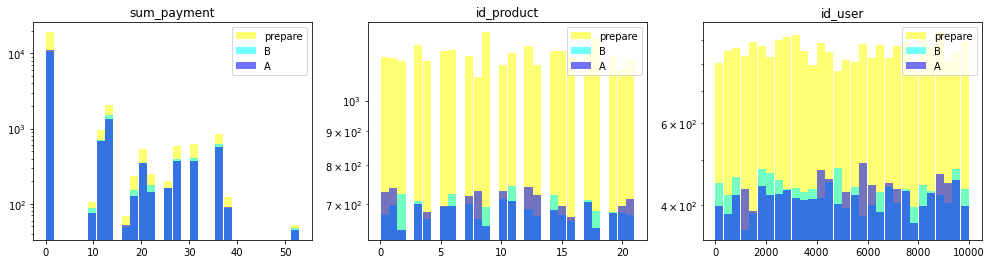

In [9]:
data_list = []
colors = ["yellow", "cyan",  "blue"]
labels = ["prepare", "B", "A",]
for group_ in labels:
    data_list.append(data[(data["group"] == group_)])

num_cols = ["sum_payment", "id_product", "id_user"]
plot_hist(data_list, labels, colors, num_cols, col_number=3, figsize_=(17, 4), bins_=30, log_y=True)

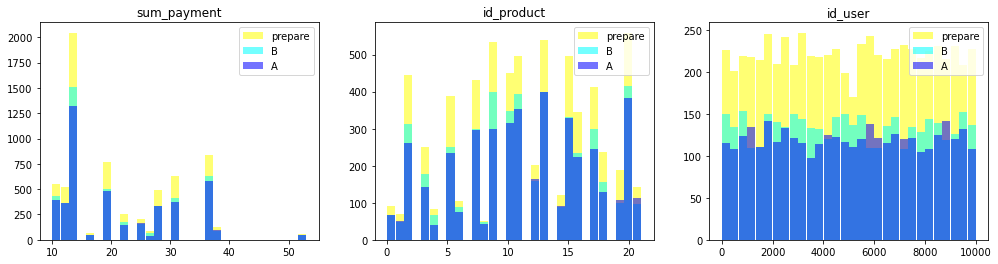

In [10]:
data_list = []
colors = ["yellow", "cyan",  "blue"]
labels = ["prepare", "B", "A",]
for group_ in labels:
    data_list.append(data[(data["group"] == group_) & (data["is_pay"] == 1)])

num_cols = ["sum_payment", "id_product", "id_user"]
plot_hist(data_list, labels, colors, num_cols, col_number=3, figsize_=(17, 4), bins_=30)

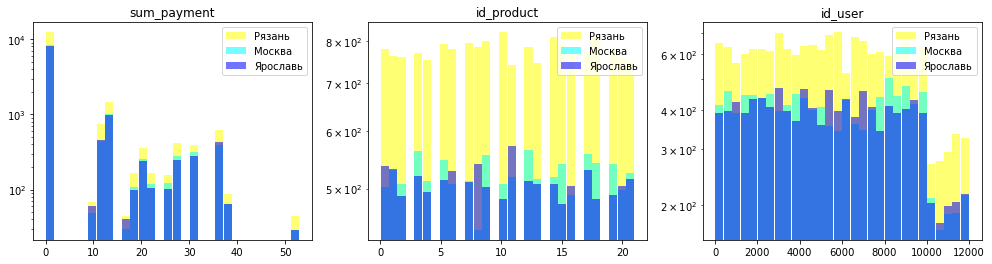

In [11]:
cities = list(data[data["is_pay"] == 1]["city"].value_counts().index)

data_list = []
colors = ["yellow", "cyan",  "blue"]
labels = cities[:3]
for group_ in labels:
    data_list.append(data[(data["city"] == group_)])

num_cols = ["sum_payment", "id_product", "id_user"]
plot_hist(data_list, labels, colors, num_cols, col_number=3, figsize_=(17, 4), bins_=30, log_y=True)

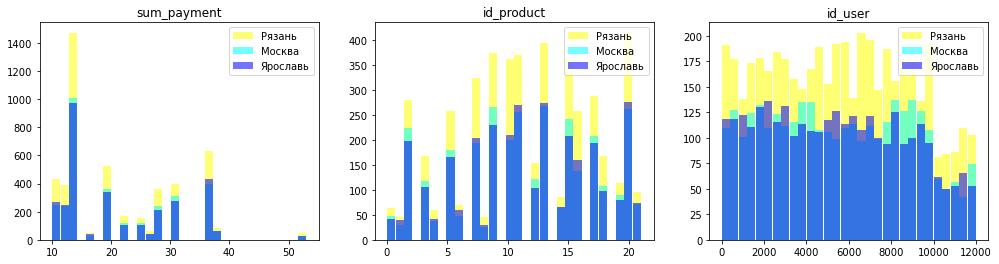

In [12]:
cities = list(data[data["is_pay"] == 1]["city"].value_counts().index)

data_list = []
colors = ["yellow", "cyan",  "blue"]
labels = cities[:3]
for group_ in labels:
    data_list.append(data[(data["city"] == group_) & (data["is_pay"] == 1)])

num_cols = ["sum_payment", "id_product", "id_user"]
plot_hist(data_list, labels, colors, num_cols, col_number=3, figsize_=(17, 4), bins_=30)

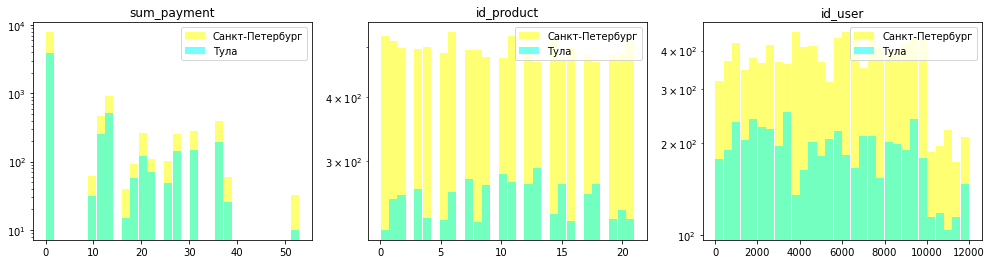

In [13]:
data_list = []
colors = ["yellow", "cyan"]
labels = cities[3:]
for group_ in labels:
    data_list.append(data[(data["city"] == group_)])

plot_hist(data_list, labels, colors, num_cols, col_number=3, figsize_=(17, 4), bins_=30, log_y=True)

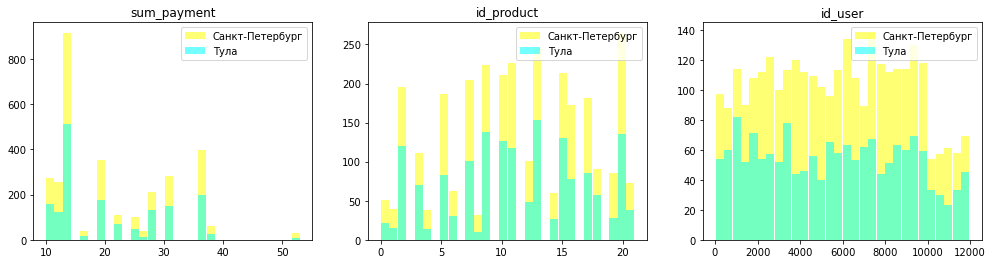

In [14]:
data_list = []
colors = ["yellow", "cyan"]
labels = cities[3:]
for group_ in labels:
    data_list.append(data[(data["city"] == group_) & (data["is_pay"] == 1)])

plot_hist(data_list, labels, colors, num_cols, col_number=3, figsize_=(17, 4), bins_=30)

#### Распределение покупок по городам схожее 

In [15]:
data.groupby(["is_pay", "group"])["date"].agg(["count"])

count
is_pay group         
0      A        11020
       B        10484
       prepare  19117
1      A         4369
       B         4773
       prepare   6642

In [16]:
data.groupby([ "city", "group"])["date"].agg(["count"])

count
city            group         
Москва          A         3167
                B         3010
                prepare   5327
Рязань          A         4649
                B         4740
                prepare   7745
Санкт-Петербург A         2971
                B         3062
                prepare   4903
Тула            A         1500
                B         1562
                prepare   2514
Ярославь        A         3102
                B         2883
                prepare   5270

### Выводы EDA
 - Количество покупок по группам A и B схожее:
        - в общем
        - в разрезе городов 
        - в разере "id_product"
        - в разрезе реакции на предложение на покупки

 - Стратиграфия по городам не требуется
 - Выбросы по сумме были на трех покупках, сумма покупок ыла скорректирована на значени 53.

## 1. Длительность теста

#### Эффектом для AB теста будем считать изменение среднего по сумме покупок на 10%

#### Посчитаем на всех данных до проведения теста двумя способами:  

 - группируя по user_id и ограничивая неделей возможность покупки после показа
 - и не группируя

In [17]:
def duration(k, delta_effect, sigma_1, sigma_2, alpha=0.05, beta=0.2):
    z = sps.norm.ppf(1 - alpha/2) + sps.norm.ppf(1-beta)
    n = (k+1) * z ** 2 * (sigma_1 ** 2 + sigma_2 **2 / k) / (delta_effect ** 2)
    return n

In [18]:
stats_prepare = data[data["group"] == "prepare"]["sum_payment"].agg(["mean", "std"])
stats_prepare

mean     5.442874
std     10.446083
Name: sum_payment, dtype: float64

In [19]:
effect = stats_prepare["mean"] * 0.1
ab_test_dur = int(duration(1, effect, stats_prepare["std"], stats_prepare["std"], alpha=0.05, beta=0.2))
ab_test_dur

11564

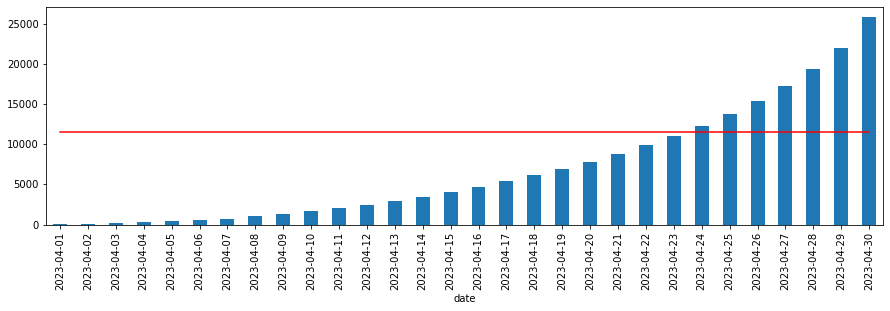

In [20]:
ax = data[data["group"] == "prepare"].groupby("date")["date"].count().cumsum().plot.bar(figsize=(15, 4))
ax.plot([ab_test_dur] * 30, "r");

In [21]:
def calc_payment_for_week(data_):
    user_min_date = data_.groupby("id_user")["date"].min().reset_index(name='min_date')
    user_min_date["max_date"] = user_min_date["min_date"] +  timedelta(days=7)
    data_ = data_.merge(user_min_date, on='id_user')
    data_ = data_[data_['date'] <= data_['max_date']] # условие ни минимум выполняется автоматически
    data_sum = data_.groupby("id_user")["sum_payment"].sum().reset_index()
    data_sum = data_sum.merge(user_min_date, on='id_user')
    return data_sum

data_prepare = calc_payment_for_week(data[data["group"] == "prepare"])
data_prepare.sample(5)

,id_user,sum_payment,min_date,max_date
7896,7896,0,2023-04-16,2023-04-23
8767,8767,0,2023-04-26,2023-05-03
3500,3500,93,2023-04-27,2023-05-04
2411,2411,0,2023-04-18,2023-04-25
9193,9193,0,2023-04-17,2023-04-24


In [22]:
stats_prepare = data_prepare["sum_payment"].agg(["mean", "std"])
stats_prepare

mean    11.287900
std     17.096176
Name: sum_payment, dtype: float64

In [23]:
effect = stats_prepare["mean"] * 0.1
ab_test_dur = int(duration(1, effect, stats_prepare["std"], stats_prepare["std"], alpha=0.05, beta=0.2))
ab_test_dur

7201

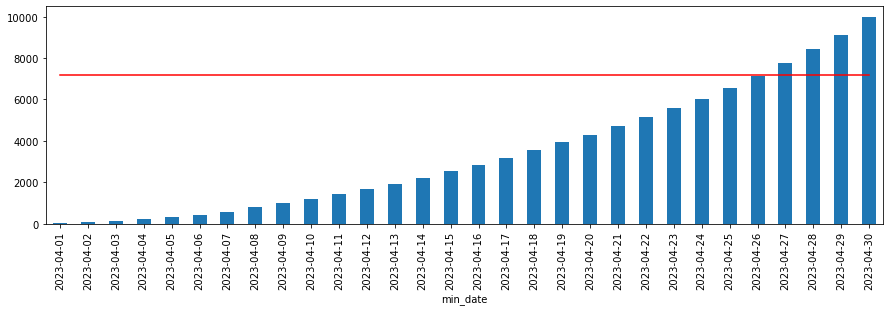

In [24]:
ax = data_prepare.groupby("min_date")["max_date"].count().cumsum().plot.bar(figsize=(15, 4))
ax.plot([ab_test_dur] * 30, "r");

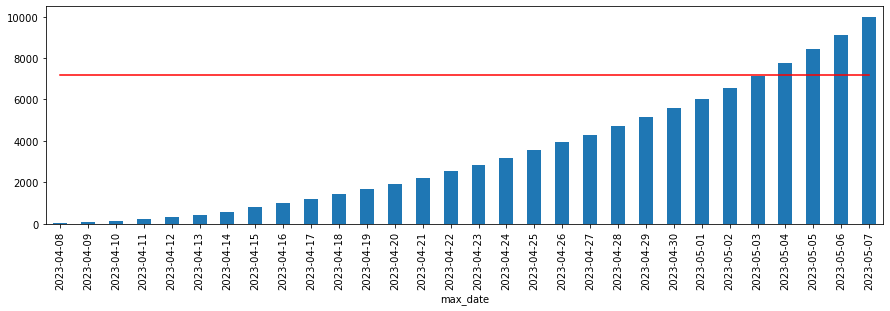

In [25]:
ax = data_prepare.groupby("max_date")["max_date"].count().cumsum().plot.bar(figsize=(15, 4))
ax.plot([ab_test_dur] * 30, "r");

### Вывод по длительности
  - По данным с пред экспериментального периода проведена оценка длительности теста:
      - без группировки по user_id оценка - 24 сутки
      - с группировки по user_id оценка - 26 суток (по первой дате показа) 
      - с группировки по user_id оценка - 33 суток (по первой дате показа + 1 неделя)
    
    По предыдущему анализу было выявлено, что если осуществляется покупка то она происходит либо в тот же день либо на следующий. То есть нам возможно не обязательно ждать неделю, что бы поймать эффект. 
    
    Но в работу берем весь выделенный месяц (31 сутки), который предоставлен для эксперимента.
    Этого времени должно хватить для проведения AB теста. Решение по результатам теста будет приниматься на 31 сутки. 

## Целевая метрика, эффект, p_value.

In [26]:
data_A = calc_payment_for_week(data[data["group"] == "A"])
data_B = calc_payment_for_week(data[data["group"] == "B"])
data_A.shape, data_B.shape

((6000, 4), (6000, 4))

In [27]:
data_A[data_A["sum_payment"] > 130]["sum_payment"]

1107    131
1784    140
2675    133
2977    161
3135    133
3782    193
3822    203
5048    136
Name: sum_payment, dtype: int64

In [28]:
data_B[data_B["sum_payment"] > 130]["sum_payment"]

124     178
951     134
1851    169
3512    152
3680    175
4269    170
4428    134
4983    133
Name: sum_payment, dtype: int64

### Только явные выбросы по sum_payment заменим на число где начинается плотность данных (на 133)

In [29]:
data_B.loc[data_B[data_B["sum_payment"] > 133].index, "sum_payment"] = 133
data_A.loc[data_A[data_A["sum_payment"] > 133].index, "sum_payment"] = 133

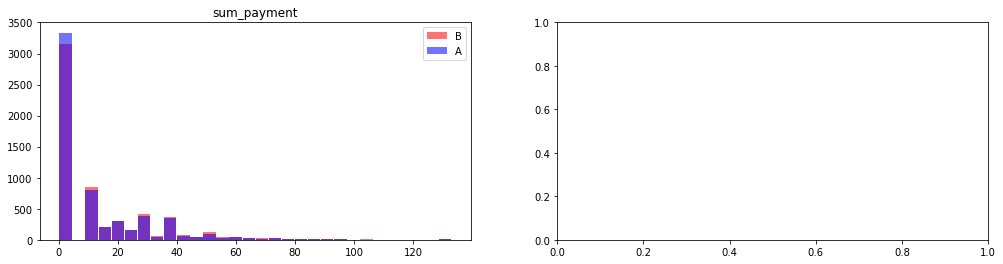

In [30]:
data_list = []
colors = ["red", "blue"]
labels = ["B", "A",]
data_list = [data_B, data_A]

num_cols = ["sum_payment"]
plot_hist(data_list, labels, colors, num_cols, col_number=2, figsize_=(17, 4), bins_=30)

In [31]:
count_A = []
mean_A = []
count_B = []
mean_B = []
p_values = []
stats = []
date_range = pd.date_range(data_A["min_date"].min(), data_A["min_date"].max())
for cur_date in date_range:
    stats_A = data_A[data_A["min_date"] <= cur_date]["sum_payment"].agg(["mean", "count"])
    mean_A.append(stats_A["mean"])
    count_A.append(stats_A["count"])
    
    stats_B = data_B[data_B["min_date"] <= cur_date]["sum_payment"].agg(["mean", "count"])
    mean_B.append(stats_B["mean"])
    count_B.append(stats_B["count"])
    
    result = sps.ttest_ind(a=mean_A, b=mean_B, equal_var=False)
    p_values.append(result.pvalue)
    stats.append(result.statistic)

In [32]:
r3 = lambda x: round(x, 3)
period_for_test = 30
print("p_value на 31 сутки:", r3(p_values[period_for_test]))
print("статистика на 31 сутки:", r3(stats[period_for_test]))
print(f"эффект на 31 сутки: {r3((mean_B[period_for_test]/mean_A[period_for_test] - 1)*100)}%")

p_value на 31 сутки: 0.039
статистика на 31 сутки: -2.133
эффект на 31 сутки: 9.4%


### Выводы
 - получен статистически значимы результат: p_value < 0.05 на 31 сутки
 - эффект около 9%-10%

## Графики по дням

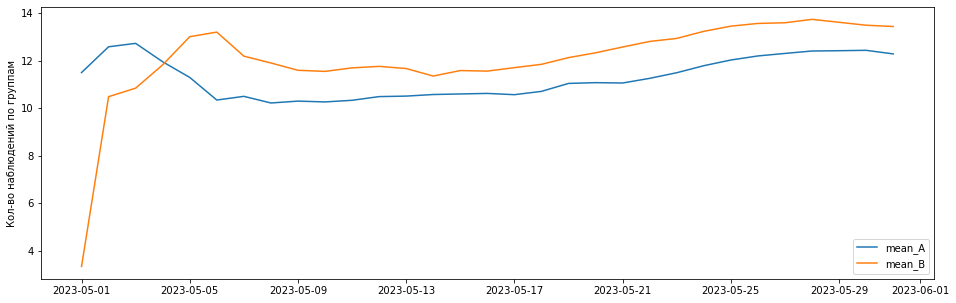

In [33]:
plt.figure(figsize=(16,5))
plt.plot(date_range, mean_A, label="mean_A");
plt.plot(date_range, mean_B, label="mean_B");
plt.legend()
plt.ylabel('Кол-во наблюдений по группам');

Text(0, 0.5, 'p_value')

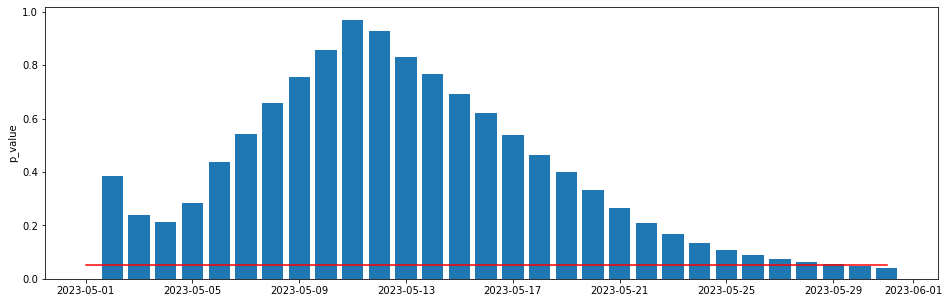

In [34]:
plt.figure(figsize=(16,5))
plt.bar(date_range, p_values);
plt.plot(date_range, [0.05] * 31, "r");
plt.ylabel('p_value')

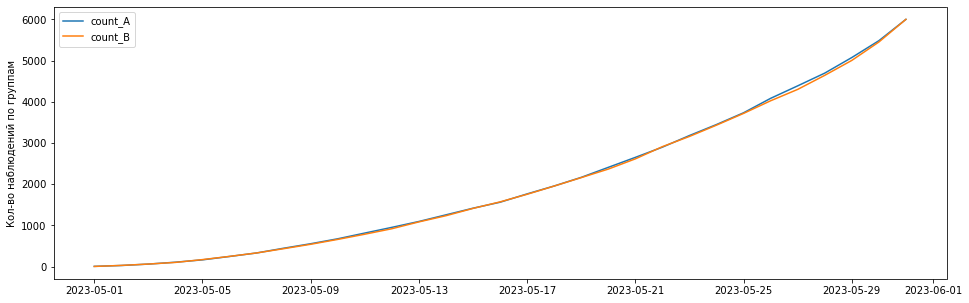

In [35]:
plt.figure(figsize=(16,5))
plt.plot(date_range, count_A, label="count_A");
plt.plot(date_range, count_B, label="count_B");
plt.legend()
plt.ylabel('Кол-во наблюдений по группам');

## Выводы
 - получен статистически значимы результат: p_value < 0.05 на 31 сутки
 - эффект около 9%-10% держиться практически весь период проведения AB теста
 - измения представленные в группе B принимаются как более эффективные